In [1]:
# This code is derived from a Pytorch tutorial available at
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# Modifications were made to fit the needs of this project.

In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 934
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) 

In [2]:
# load the dataset of flowers
from datasets import load_dataset

dataset_name = "YiwengXie/102_flowers_small"
dataset = load_dataset(dataset_name, split="train")

In [3]:
# The loaded data type (PIL) is inconsistent with the requirement of the dataloader used in this notebook
# We use the following to transform the data type into torch.tensor

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (list or similar structure): Typically this would be a list of dictionaries,
                                              where each dictionary contains 'image' and 'text' keys.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        text = item['text']

        if self.transform:
            image = self.transform(image)

        return {'image': image, 'text': text}


In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to ensure uniformity
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset_new = CustomDataset(dataset, transform=transform)

In [6]:
# We also define the following to transform tensors back into PIL for visualization

import matplotlib.pyplot as plt

def tensor_to_pil(tensor):
    """Convert a tensor to a PIL Image and unnormalize."""
    # Assuming tensor is normalized, unnormalize using mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean  # unnormalize

    # Clip to ensure valid image data
    tensor = torch.clamp(tensor, 0, 1)

    # Convert to PIL image
    to_pil = transforms.ToPILImage()
    image = to_pil(tensor)
    return image

def visualize_tensor_images(tensor_images):
    """Visualize a batch of images."""
    fig, axes = plt.subplots(nrows=1, ncols=len(tensor_images), figsize=(12, 4))
    for i, image_tensor in enumerate(tensor_images):
        image = tensor_to_pil(image_tensor)
        if len(tensor_images) == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(image)
        ax.axis('off')  # Hide the axis
    plt.show()

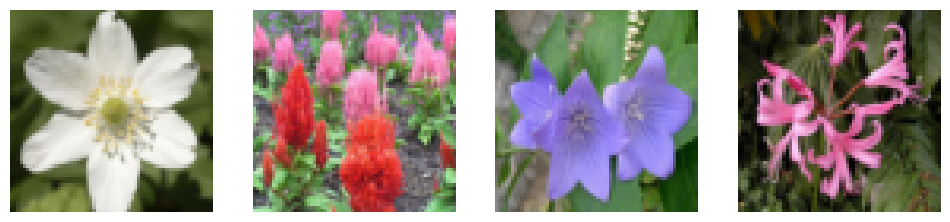

In [7]:
# Visualization of examples
dataloader = torch.utils.data.DataLoader(dataset_new, batch_size=4,shuffle=True, num_workers=1)

for batch in dataloader:
    images = batch['image']
    texts = batch['text']

# Assuming `images` is a batch of tensors from your DataLoader
visualize_tensor_images(images)

In [8]:
# Create the dataloader for training
dataloader = torch.utils.data.DataLoader(dataset_new, batch_size=128,shuffle=True, num_workers=1)

# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [9]:
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [10]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            #nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            #nn.BatchNorm2d(ngf * 16),
            #
            nn.ReLU(True),
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ReLU(inplace=True)
    (1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=F

In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 128 x 128``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #nn.BatchNorm2d(ndf * 16),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [16]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(16, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [28]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data['image'].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/20][0/13]	Loss_D: 0.6103	Loss_G: 3.5547	D(x): 0.6928	D(G(z)): 0.0538 / 0.0338


KeyboardInterrupt: 

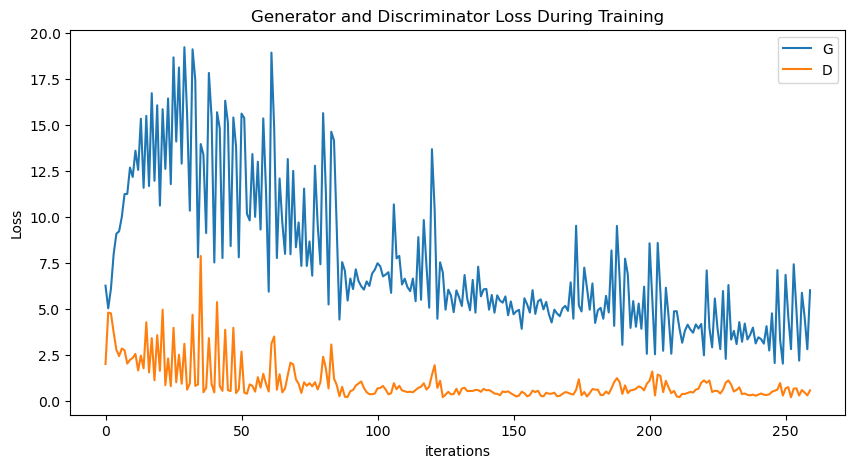

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

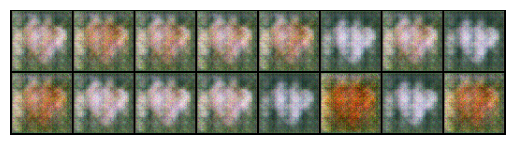

In [19]:
#plt.subplot(1,2,2)
plt.axis("off")
#plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Model Evaluation

In [33]:
# model evaluation
# we start the evaluation by generating images,
# and transforming the images into the required size for calculating the inception score

noise = torch.randn(1000, nz, 1, 1, device=device)
generated_images = netG(noise)

resize_transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

generated_images = resize_transform(generated_images)


#### The Inception Score

In [35]:
import torch
import torchvision.transforms as transforms
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images.

    imgs: Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda: If True, use GPU
    batch_size: Batch size for feeding into Inception v3
    resize: If True, resize images to (299, 299) as required by Inception v3
    splits: Number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dataloader
    dataloader = DataLoader(imgs, batch_size=batch_size)
     # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()
    if cuda:
        inception_model.cuda()

    # Get prediction probabilities
    def get_preds(x):
        if resize:
            x = transforms.functional.resize(x, (299, 299))
        if cuda:
            x = x.cuda()
        x = inception_model(x)
        return torch.nn.functional.softmax(x, dim=1).detach().cpu().numpy()

    # Calculate scores
    preds = np.concatenate([get_preds(batch) for batch in dataloader], axis=0)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        p_y = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            p_yx = part[i, :]
            scores.append(entropy(p_yx, p_y))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# Compute the Inception Score
mean_is, std_is = inception_score(generated_images, cuda=True, batch_size=32, resize=False, splits=10)

print(f"Inception Score: {mean_is:.2f} ± {std_is:.2f}")

/home/goldenbean/miniconda3/envs/diffuser_image/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/goldenbean/miniconda3/envs/diffuser_image/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 1.21 ± 0.01


#### The FID score

In [44]:
# sample and transform and resize the ground truth images

test_loader = torch.utils.data.DataLoader(dataset_new, batch_size=1000,shuffle=True, num_workers=1)

test_iter = iter(test_loader)
test_data = next(test_iter)
ground_truth_images = test_data['image']
ground_truth_images = resize_transform(ground_truth_images)

In [45]:
from scipy.linalg import sqrtm

def get_inception_features(images, model, batch_size, device):
    model.eval()
    features = []
    with torch.no_grad():
        for batch in DataLoader(images, batch_size=batch_size):
            batch = batch.to(device)
            feat = model(batch)
            features.append(feat.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features

def calculate_fid(real_features, fake_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = inception_v3(pretrained=True)
inception_model.fc = torch.nn.Identity()
inception_model.to(device)

real_features = get_inception_features(ground_truth_images, inception_model, batch_size=50, device=device)
fake_features = get_inception_features(generated_images, inception_model, batch_size=50, device=device)
fid_score = calculate_fid(real_features, fake_features)
print("FID Score:", fid_score)

/home/goldenbean/miniconda3/envs/diffuser_image/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/goldenbean/miniconda3/envs/diffuser_image/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score: 324.70400614533065
